# Few-Shot with a RidgeClassifier
Creates a model that combines pybioclip image embeddings with a RidgeClassifier using images from the [Somnath01/Birds_Species](https://huggingface.co/datasets/Somnath01/Birds_Species) dataset. This dataset contains 1000 train images, 403 test images, and 50 validation images. This notebook only uses the train and test images. This dataset was chosen for convenience. No analysis of the suitability of this dataset has been done.

When running this notebook in COLAB change the _runtime type_ to a GPU type to speed up processing. Additionally when running the next step in COLAB you you may see an error about the version of `fsspec` installed. This issue doesn't seem to cause any problem with this notebook.

In [1]:
!pip install -q numpy datasets pybioclip scikit-learn matplotlib

In [2]:
import itertools
import numpy as np
from tqdm.notebook import tqdm

import torch
from datasets import load_dataset

from bioclip.predict import BaseClassifier

import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.experimental.enable_halving_search_cv
import sklearn.linear_model
import scipy.stats
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Dataset settings
HF_DATASET_NAME = "Somnath01/Birds_Species"
TRAIN_NAME = 'train'
TEST_NAME = 'test'
IMAGE_NAME = 'image'
LABEL_NAME = 'label'

# Image embedding settings
BATCH_SIZE = 30

## Determine GPU or CPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Load dataset
This step takes around 7 minutes to download the images the first time it is run.

### Setting up HF_TOKEN (Recommended for Google Colab)

You may see warnings `The secret 'HF_TOKEN' does not exist in your Colab secrets.` when running the code block below. To avoid rate limiting errors when running in Google Colab, follow these steps to set up your HuggingFace token:

1. **Create a HuggingFace account and token:**
   - Go to [https://huggingface.co/](https://huggingface.co/) and create an account if you don't have one
   - Navigate to your [Access Tokens page](https://huggingface.co/settings/tokens)
   - Click "New token" and create a token with "Read" permissions
   - Copy the generated token

2. **Add the token as a Colab secret:**
   - In Google Colab, click the key icon (🔑) in the left sidebar to open the Secrets panel
   - Click "Add new secret"
   - Set the name to `HF_TOKEN`
   - Paste your HuggingFace token as the value
   - Click "Add secret"

3. **Grant notebook access to the secret:**
   - In the Secrets panel, find your `HF_TOKEN` secret
   - Toggle the switch next to the notebook name to grant access
   - The switch should turn blue/green when enabled

After setting up the token, restart your runtime (Runtime → Restart runtime) and re-run the cells above before proceeding.

In [5]:
dataset = load_dataset(HF_DATASET_NAME)
dataset

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/403 [00:00<?, ?it/s]

025.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/29.2k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/39.4k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/31.3k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/8.82k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/8.94k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/8.90k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/8.49k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/9.72k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/41.0k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/36.6k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/43.1k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/37.9k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/35.4k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/34.3k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/8.85k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/35.4k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/34.7k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/31.0k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/28.0k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/32.5k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/39.9k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/36.6k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/35.4k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/29.6k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/33.2k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/32.7k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/31.9k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/28.0k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/34.3k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/29.0k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/28.5k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/32.7k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/32.4k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/34.3k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/28.5k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/8.10k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/31.3k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/29.5k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/31.9k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/28.0k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/23.8k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/32.1k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/36.3k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/9.52k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/29.0k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/32.4k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/32.1k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/32.5k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/28.0k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/19.2k [00:00<?, ?B/s]

002.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

003.jpg:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

005.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

006.jpg:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

004.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

007.jpg:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

001.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

009.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

008.jpg:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

010.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

012.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

016.jpg:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

015.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

011.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

014.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

013.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

021.jpg:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

022.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

018.jpg:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

017.jpg:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

023.jpg:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

025.jpg:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

026.jpg:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

024.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

028.jpg:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

020.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

027.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

029.jpg:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

030.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

031.jpg:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

019.jpg:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

032.jpg:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

033.jpg:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

034.jpg:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

035.jpg:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

041.jpg:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

042.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

037.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

039.jpg:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

044.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

045.jpg:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

038.jpg:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

046.jpg:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

043.jpg:   0%|          | 0.00/8.09k [00:00<?, ?B/s]

036.jpg:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

040.jpg:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

047.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

048.jpg:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

049.jpg:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

051.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

050.jpg:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

053.jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

052.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

054.jpg:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

055.jpg:   0%|          | 0.00/38.6k [00:00<?, ?B/s]

057.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

056.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

058.jpg:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

059.jpg:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

060.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

062.jpg:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

061.jpg:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

064.jpg:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

065.jpg:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

063.jpg:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

067.jpg:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

066.jpg:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

069.jpg:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

070.jpg:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

071.jpg:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

068.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

072.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

073.jpg:   0%|          | 0.00/9.81k [00:00<?, ?B/s]

074.jpg:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

075.jpg:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

077.jpg:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

076.jpg:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

079.jpg:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

078.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

081.jpg:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

080.jpg:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

082.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

083.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

084.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

087.jpg:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

089.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

086.jpg:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

090.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

091.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

093.jpg:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

092.jpg:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

094.jpg:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

088.jpg:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

085.jpg:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

095.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

097.jpg:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

096.jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

099.jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

098.jpg:   0%|          | 0.00/30.0k [00:00<?, ?B/s]

100.jpg:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/36.6k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/23.8k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/33.2k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/34.7k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

158.jpg:   0%|          | 0.00/9.56k [00:00<?, ?B/s]

148.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

152.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

160.jpg:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

147.jpg:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

162.jpg:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

161.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

150.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

149.jpg:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

163.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

151.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

146.jpg:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

159.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

102.jpg:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

101.jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

113.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

103.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

115.jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

106.jpg:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

114.jpg:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

105.jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

104.jpg:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

117.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

118.jpg:   0%|          | 0.00/29.2k [00:00<?, ?B/s]

126.jpg:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

127.jpg:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

116.jpg:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

125.jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

129.jpg:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

128.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

130.jpg:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

159.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

147.jpg:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

148.jpg:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

151.jpg:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

152.jpg:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

160.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

150.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

161.jpg:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

149.jpg:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

162.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

163.jpg:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

164.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

171.jpg:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

172.jpg:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

174.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

173.jpg:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

175.jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

176.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

125.jpg:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

135.jpg:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

127.jpg:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

126.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

138.jpg:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

124.jpg:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

123.jpg:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

136.jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

137.jpg:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

147.jpg:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

139.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

110.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

112.jpg:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

122.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

123.jpg:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

111.jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

109.jpg:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

133.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

121.jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

113.jpg:   0%|          | 0.00/33.2k [00:00<?, ?B/s]

125.jpg:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

124.jpg:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

128.jpg:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

129.jpg:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

131.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

130.jpg:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

140.jpg:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

102.jpg:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

103.jpg:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

115.jpg:   0%|          | 0.00/35.1k [00:00<?, ?B/s]

105.jpg:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

116.jpg:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

114.jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

117.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

104.jpg:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

102.jpg:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

103.jpg:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

103.jpg:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

101.jpg:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

112.jpg:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

102.jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

106.jpg:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

104.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

105.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

114.jpg:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

113.jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

117.jpg:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

116.jpg:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

118.jpg:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

115.jpg:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

124.jpg:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

125.jpg:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

126.jpg:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

138.jpg:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

142.jpg:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

141.jpg:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

139.jpg:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

140.jpg:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

1.jpg:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

3.jpg:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

4.jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

5.jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

2.jpg:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/403 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 403
    })
})

Labels: ABBOTTS BABBLER,ABBOTTS BOOBY,ABYSSINIAN GROUND HORNBILL,AFRICAN CROWNED CRANE,AFRICAN EMERALD CUCKOO,AFRICAN FIREFINCH,AFRICAN OYSTER CATCHER,AFRICAN PIED HORNBILL,AFRICAN PYGMY GOOSE,ALBATROSS 

Example Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x30D99A740>


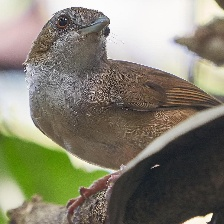

In [6]:
print("Labels:", ",".join(dataset[TRAIN_NAME].features[LABEL_NAME].names), "\n")
print("Example Image:", dataset[TRAIN_NAME][IMAGE_NAME][0])
dataset[TRAIN_NAME][IMAGE_NAME][0]

## Function to Convert PIL to image embeddings

In [7]:
classifier = BaseClassifier(device=device)

In [8]:
def batched(items, batch_size):
    it = iter(items)
    while (batch := list(itertools.islice(it, batch_size))):
          yield batch

In [9]:
def create_image_features(pil_image_ary):
    # batch PIL -> features transformation
    all_features = []
    with tqdm(total=len(pil_image_ary), desc='Creating image embeddings', unit='image') as progress_bar:
        for images in batched(pil_image_ary, BATCH_SIZE):
            features = classifier.create_image_features(images, normalize=True)
            all_features.append(features.cpu())
            progress_bar.update(len(images))
    return torch.cat(all_features, dim=0).cpu().numpy()

## Function to show prediction metrics

In [10]:
def show_metrics(expected_label_ary, predicted_label_ary):
    print("Accuracy:", round(accuracy_score(expected_label_ary, predicted_label_ary), 3))
    cm = confusion_matrix(expected_label_ary, predicted_label_ary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title("Confusion Matrix")
    plt.show()

## Setup a RidgeClassifier model
The `init_clf()` function is simplfied from [biobench plantnet](https://github.com/samuelstevens/biobench/blob/637432bfda2b567d966d49bf8c4b37b339d4dc2a/biobench/plantnet/__init__.py#L212C1-L228C6) 
created by [@samuelstevens](https://github.com/samuelstevens).

In [11]:
def init_clf():
    return sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.linear_model.RidgeClassifier(),
        )

In [12]:
# Create a model that preprocesses images into feature embeddings that are passed to the RidgeClassifier
model = sklearn.pipeline.make_pipeline(
    FunctionTransformer(create_image_features),
    init_clf(),
)

## Train the RidgeClassifier model
Trains the model using the train dataset. This step takes ~ 8 minutes when running on CPU and ~1 minute otherwise.

In [13]:
# Convert dataset columns to lists for Colab compatibility (sklearn requires list-like objects)
model.fit(list(dataset[TRAIN_NAME][IMAGE_NAME]), list(dataset[TRAIN_NAME][LABEL_NAME]))

Creating image embeddings:   0%|          | 0/1000 [00:00<?, ?image/s]

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function create_image_features at 0x336105f30>)),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('ridgeclassifier', RidgeClassifier())]))])

## Create predictions
Predicts species for the test dataset. This step takes ~ 4 minutes when running on CPU and ~1 minute otherwise.

Creating image embeddings:   0%|          | 0/403 [00:00<?, ?image/s]

Accuracy: 0.998


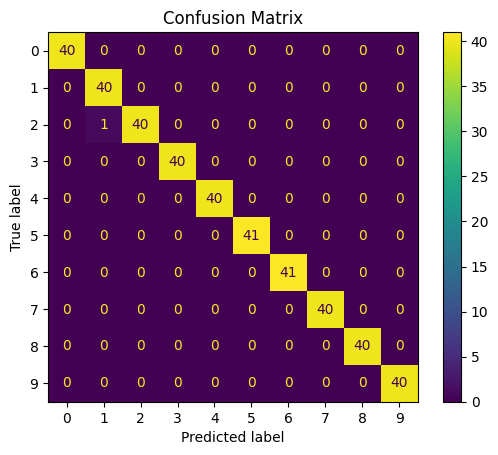

In [14]:
# Convert dataset columns to lists for Colab compatibility (sklearn requires list-like objects)
predicted_labels = model.predict(list(dataset[TEST_NAME][IMAGE_NAME]))
show_metrics(predicted_labels, list(dataset[TEST_NAME][LABEL_NAME]))

## Compare against direct zero-shot pybioclip predictions
This step takes ~ 6 minutes when running on CPU and ~1 minute otherwise.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 18.87images/s]

Accuracy: 0.985


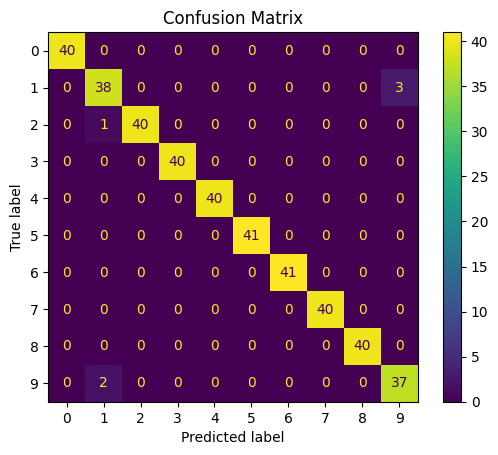

In [15]:
from bioclip.predict import CustomLabelsClassifier
classifier = CustomLabelsClassifier(dataset[TEST_NAME].features[LABEL_NAME].names, device=device)
predicted_labels = []
# Convert dataset columns to lists for Colab compatibility
for images in batched(list(dataset[TEST_NAME][IMAGE_NAME]), BATCH_SIZE):
    predictions = classifier.predict(images, k=1)
    for pred in predictions:
        label_str = pred['classification']
        label = dataset[TEST_NAME].features[LABEL_NAME].str2int(label_str)
        predicted_labels.append(label)
# Convert dataset columns to lists for Colab compatibility
show_metrics(predicted_labels, list(dataset[TEST_NAME][LABEL_NAME]))